# Application of Frenkel-Halsey-Hill and Derjaguin-Broekhoff-de Boer theories on data from [Cychosz, Katie A., et al., Langmuir 28.34 (2012): 12647-12654](https://doi.org/10.1021/la302362h)

In [1]:
%run __imports.ipynb
from CoolProp.CoolProp import PropsSI as props

# Reference parameters

In [2]:
P_atm = 101325  # Pa
species = "Argon"
temperature = np.round(props("T", "P", P_atm, "Q", 0, species), 2)
surface_tension = props("SURFACE_TENSION", "T", temperature, "P", P_atm, species)  # N/m
molar_volume = 1.0 / props("Dmolar", "T", temperature, "P", P_atm, species)  # m3/mol

In [3]:
columns = ["species", "temperature $T$, K", "surface tension $\gamma$, mN/m", "molar volume $V_l$, mL/mol"]
values = [species, temperature, surface_tension * 1e3, molar_volume * 1e6]
df = pd.DataFrame(columns=columns)
df.loc[0] = values
df

,species,"temperature $T$, K","surface tension $\gamma$, mN/m","molar volume $V_l$, mL/mol"
0,Argon,87.3,12.534506,28.628176


Frenkel-Halsey-Hill fit
======================

In [4]:
# Fig. 2 in Gardner L et al, JPC 2001 https://doi.org/10.1021/jp011745+
data = np.genfromtxt("../data/arc/BP_fig2_87K.tsv", names=True)
pressure = data["p_rel"]
density = data["Q_cm3_per_g_STP"] / (dbdb.V_m * 1e3)
ar_csa = 0.138e-18  # cross-sectional area, m2
s_a = bet.surface_area(pressure, density, csa=ar_csa) * 1e3
inst = dbdb.Dbdb(T=temperature, V_l=molar_volume, gamma=surface_tension, reference_s_a=s_a)
fhh_k, fhh_m = inst.fhh_fit(pressure, density)

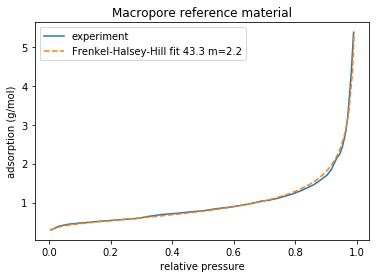

In [5]:
plt.plot(pressure, density, label="experiment")
plt.plot(
    inst.relative_pressure_macropore(density, fhh_k, fhh_m),
    density,
    "--",
    label=f"Frenkel-Halsey-Hill fit {fhh_k:.1f} m={fhh_m:.1f}",
)
plt.xlabel("relative pressure")
plt.ylabel("adsorption (g/mol)")
plt.title("Macropore reference material")
plt.legend()
plt.show()

In [6]:
exp_pore_size = 20
data = np.genfromtxt(f"../data/arc/arc_{exp_pore_size}nm.tsv", names=True)
pressure_exp = data["P"]
density_exp = data["V"]
density_exp = density_exp / np.max(density_exp)

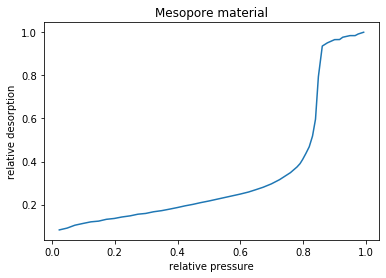

In [7]:
plt.plot(pressure_exp, density_exp)
plt.xlabel("relative pressure")
plt.ylabel("relative desorption")
plt.title("Mesopore material")
plt.show()

Isotherm Kernel based on Derjaguin-Broekhoff-de Boer theory
====================================

In [8]:
if exp_pore_size < 30:
    pore_sizes = np.arange(1, 56, 2)
else:
    pore_sizes = np.arange(20, 56, 2)

kernel = inst.kernel(pressure_exp, pore_sizes, fhh_k, fhh_m)

In [9]:
df = pd.DataFrame(kernel)
df.columns = [f"d = {d} nm" for d in pore_sizes]
df.index = [f"p/p0 = {d:.2f}" for d in pressure_exp]
df

,d = 1 nm,d = 3 nm,d = 5 nm,d = 7 nm,d = 9 nm,...,d = 47 nm,d = 49 nm,d = 51 nm,d = 53 nm,d = 55 nm
p/p0 = 0.02,1.0,0.529797,0.332458,0.242297,0.190593,...,0.037690,0.036163,0.034755,0.033452,0.032244
p/p0 = 0.05,1.0,0.584989,0.365483,0.266212,0.209373,...,0.041403,0.039726,0.038179,0.036748,0.035420
p/p0 = 0.07,1.0,0.629694,0.390801,0.284372,0.223576,...,0.044189,0.042399,0.040748,0.039220,0.037804
p/p0 = 0.10,1.0,0.675033,0.414575,0.301242,0.236716,...,0.046745,0.044851,0.043104,0.041488,0.039989
p/p0 = 0.12,1.0,0.718396,0.434823,0.315440,0.247724,...,0.048868,0.046887,0.045061,0.043372,0.041805
...,...,...,...,...,...,...,...,...,...,...,...
p/p0 = 0.93,1.0,1.000000,1.000000,1.000000,1.000000,...,0.291151,0.272350,0.256261,0.242250,0.229889
p/p0 = 0.95,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.459798,0.381649
p/p0 = 0.96,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000
p/p0 = 0.97,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000


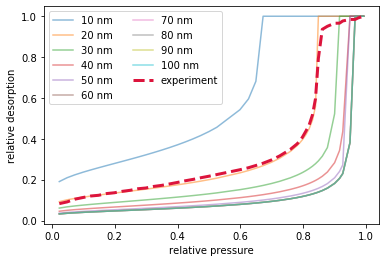

In [10]:
display_pores_sizes = pore_sizes if len(pore_sizes) < 5 else np.arange(10, 110, 10)
for d in display_pores_sizes:
    psz_idx = np.abs(pore_sizes - d).argmin()
    plt.plot(pressure_exp, kernel[:, psz_idx], "-", label=f"{d} nm", alpha=0.5)

plt.plot(pressure_exp, density_exp, label="experiment", ls="--", lw=3, color="crimson")
plt.legend(ncol=2)
plt.xlabel("relative pressure")
plt.ylabel("relative desorption")
plt.show()

Solution of the integral equation
================================

In [11]:
psd = scipy.optimize.nnls(kernel, density_exp)[0]
solution = kernel @ psd

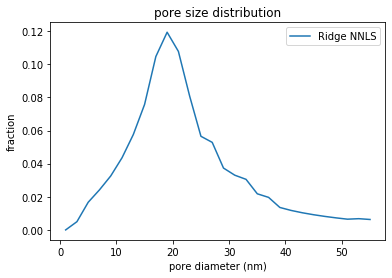

In [12]:
alpha = np.concatenate(([1e-7], np.linspace(0, 1e4, 1001)[1:]))
psd_rnnls = RidgeNNLS(alphas=np.power(alpha, 2)).fit(kernel, density_exp, alpha=4).coef_
plt.plot(pore_sizes, psd_rnnls, label="Ridge NNLS")

# plt.plot(pore_sizes, psd, label="NNLS")
plt.xlabel("pore diameter (nm)")
plt.ylabel("fraction")
plt.title("pore size distribution")
plt.legend()
plt.show()

[]

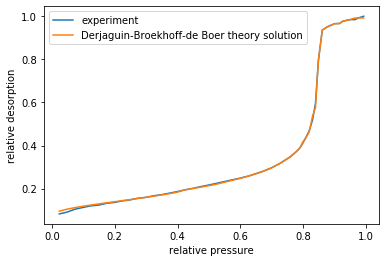

In [13]:
plt.plot(pressure_exp, density_exp, label="experiment")
plt.plot(pressure_exp, solution, label="Derjaguin-Broekhoff-de Boer theory solution")
plt.legend()
plt.xlabel("relative pressure")
plt.ylabel("relative desorption")
plt.plot()